In [1]:
import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from imblearn.over_sampling import RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [93]:
data = pd.read_csv("creditcard.csv")

data.head()

data['Class'].value_counts()

len(data['Class'])

print("percentage of fraudulent data instances: {}".format(data['Class'].value_counts()[1] *100 /len(data['Class'])))
print("percentage of normal data instances: {}".format(data['Class'].value_counts()[0] *100 /len(data['Class'])))

# Rescaling the data



rs = RobustScaler()

data['scaled_amount'] = rs.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = rs.fit_transform(data['Time'].values.reshape(-1, 1))

data.drop(['Amount', 'Time'], axis = 1, inplace = True)


# from sklearn.linear_model import LogisticRegression

X = data.drop(['Class'], axis = 1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, 
                                                    stratify = y)

print(X_train.shape, y_train.shape)
print(y_train.value_counts())



percentage of fraudulent data instances: 0.1727485630620034
percentage of normal data instances: 99.827251436938
(227845, 30) (227845,)
0    227451
1       394
Name: Class, dtype: int64


In [38]:
all_dataset=dict()

In [39]:
all_results=[]

In [40]:
 def training_testing_function(X,y,name):
        
        #removing highly correlated features
        corr = X.corr()
        columns = np.full((corr.shape[0],), True, dtype=bool)
        for i in range(corr.shape[0]):
            for j in range(i+1, corr.shape[0]):
                if corr.iloc[i,j] >= 0.8:
                    if columns[j]:
                        columns[j] = False
        selected_columns = X.columns[columns]
        X1 = X[selected_columns]
        
         # Train KNeighborsClassifier Model
#         KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
        
        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=400)

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        # DTC_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());
        
        XGB_Classifier = XGBClassifier(scale_pos_weight=500)
        

        ## Train Ensemble Model (This method combines all the individual models above except RandomForest)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
#                          ('KNeighborsClassifier', KNN_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                          ('Gradient Boosting Classifier', XGB_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X1, y.values.ravel());

        models = []
        models.append(('VotingClassifier', VC))

        for i, v in models:
            accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[selected_columns]))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X_test[selected_columns]))
            auc_score = metrics.roc_auc_score(y_test.values.ravel(),v.predict(X_test[selected_columns]))
            confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[selected_columns]))
            classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[selected_columns]))

            
            all_results.append((name+str(" RCF"),accuracy,f1,auc_score,confusion_matrix,classification)) #RCF = Removing correlated features
            print("{} Completed".format(name + str(" RCF")))
        
        
        
        
      

        rfc = RandomForestClassifier();

        # fit random forest classifier on the training set
        rfc.fit(X, y.values.ravel());
        # extract important features
        score = np.round(rfc.feature_importances_,3)

        importances = pd.DataFrame({'feature':X.columns,'importance':score})
        importances = importances.sort_values('importance',ascending=False).set_index('feature')

        min_features=min(len(importances),20)
        
        final_features=list(importances[:20].index)

        X2=X[final_features]

        # Train KNeighborsClassifier Model
#         KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
        # KNN_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel()); 

        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=400)
        # LGR_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()
        # GNB_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel())

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        # DTC_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());
        
        XGB_Classifier = XGBClassifier(scale_pos_weight=500)

        ## Train Ensemble Model (This method combines all the individual models above except RandomForest)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
#                          ('KNeighborsClassifier', KNN_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                        ('Gradient Boosting Classifier', XGB_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X2, y.values.ravel());

        models = []

        models.append(('VotingClassifier', VC))

        for i, v in models:
            accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[final_features]))
            confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[final_features]))
            classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[final_features]))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X_test[final_features]))
            auc_score = metrics.roc_auc_score(y_test.values.ravel(),v.predict(X_test[final_features]))
        
            all_results.append((name+str(" Random Forest  Selection"),accuracy,f1,auc_score,confusion_matrix,classification))
            print("{} Completed".format(name+str(" Random Forest Selection")))

            
        fs = SelectKBest(score_func=f_classif, k=5)
        # apply feature selection
        fs.fit(X, y)
        X3 = fs.transform(X)
        X3_test = fs.transform(X_test)

                  
     # Train KNeighborsClassifier Model
#         KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
        # KNN_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel()); 

        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=400)
        # LGR_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()
        # GNB_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel())

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        # DTC_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());
        
        XGB_Classifier = XGBClassifier(scale_pos_weight=500)

        ## Train Ensemble Model (This method combines all the individual models above except RandomForest)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
#                          ('KNeighborsClassifier', KNN_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                         ('Gradient Boosting Classifier', XGB_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X3, y.values.ravel());

        models = []

        models.append(('VotingClassifier', VC))

        for i, v in models:
            accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X3_test))
            confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X3_test))
            classification = metrics.classification_report(y_test.values.ravel(), v.predict(X3_test))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X3_test))
            auc_score = metrics.roc_auc_score(y_test.values.ravel(),v.predict(X3_test))
        
            all_results.append((name+str(" Forward feature selection"),accuracy,f1,auc_score,confusion_matrix,classification))
            print("{} Completed".format(name+str(" Forward feature selection")))


#### 1. Random Undersample

In [95]:
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
all_dataset["X_train_undersample"], all_dataset["y_train_undersample"] = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(all_dataset["y_train_undersample"]))

Counter({0: 394, 1: 394})


In [96]:
training_testing_function(all_dataset["X_train_undersample"],all_dataset["y_train_undersample"],"Random Undersample")

Random Undersample RCF Completed
Random Undersample Random Forest Selection Completed
Random Undersample Forward feature selection Completed


#### 2. Instance Hardness Threshold

In [97]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [98]:
iht = InstanceHardnessThreshold(sampling_strategy='majority', random_state=42)
all_dataset["X_train_res"], all_dataset["y_train_res"] = iht.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(all_dataset["y_train_res"]))

Resampled dataset shape Counter({0: 222288, 1: 394})


In [99]:
training_testing_function(all_dataset["X_train_res"],all_dataset["y_train_res"],"IHT")

IHT RCF Completed
IHT Random Forest Selection Completed
IHT Forward feature selection Completed


#### 3. Cluster Centroid

In [100]:
from imblearn.under_sampling import ClusterCentroids

In [101]:
all_dataset["X_cluster_centroids"],all_dataset["y_cluster_centroids"]  = ClusterCentroids().fit_resample(X_train,y_train)

In [102]:
training_testing_function(all_dataset["X_cluster_centroids"],all_dataset["y_cluster_centroids"],"Cluster centroids")

Cluster centroids RCF Completed
Cluster centroids Random Forest Selection Completed
Cluster centroids Forward feature selection Completed


#### 4. Near Miss

In [103]:
from imblearn.under_sampling import NearMiss

In [104]:
all_dataset['X_near_miss'],all_dataset['y_near_miss'] = NearMiss().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_near_miss'],all_dataset['y_near_miss'],"Near Miss")

Near Miss RCF Completed
Near Miss Random Forest Selection Completed
Near Miss Forward feature selection Completed


#### 5. One Sided Selection

In [105]:
from imblearn.under_sampling import OneSidedSelection

In [106]:
all_dataset['X_one_sided_selection'],all_dataset['y_one_sided_selection'] = OneSidedSelection().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_one_sided_selection'],all_dataset['y_one_sided_selection'],"One Sided Selection")

One Sided Selection RCF Completed
One Sided Selection Random Forest Selection Completed
One Sided Selection Forward feature selection Completed


#### 6. Tomek Links

In [107]:
from imblearn.under_sampling import TomekLinks

In [108]:
all_dataset['X_tomek_links'],all_dataset['y_tomek_links'] = TomekLinks().fit_resample(X_train,y_train)


In [109]:
training_testing_function(all_dataset['X_tomek_links'],all_dataset['y_tomek_links'],"Tomek Links")

Tomek Links RCF Completed
Tomek Links Random Forest Selection Completed
Tomek Links Forward feature selection Completed


In [110]:
all_results

[('Random Undersample RCF',
  0.9456830869702608,
  0.052663808940600125,
  0.9116757634398722,
  array([[53782,  3082],
         [   12,    86]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      0.95      0.97     56864\n           1       0.03      0.88      0.05        98\n\n    accuracy                           0.95     56962\n   macro avg       0.51      0.91      0.51     56962\nweighted avg       1.00      0.95      0.97     56962\n'),
 ('Random Undersample Random Forest  Selection',
  0.9635370949053755,
  0.07811806480248557,
  0.9308046481113549,
  array([[54797,  2067],
         [   10,    88]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      0.96      0.98     56864\n           1       0.04      0.90      0.08        98\n\n    accuracy                           0.96     56962\n   macro avg       0.52      0.93      0.53     56962\nweighted avg       1.00      0.96  

### Oversampling data

#### 1. Random Oversampling

In [111]:
ros = RandomOverSampler(random_state=0)
all_dataset["X_train_random_oversampled"], all_dataset["y_train_random_oversampled"] = ros.fit_resample(X_train, y_train)
from collections import Counter
print(sorted(Counter(all_dataset["y_train_random_oversampled"]).items()))

[(0, 227451), (1, 227451)]


In [112]:
training_testing_function(all_dataset["X_train_random_oversampled"],all_dataset["y_train_random_oversampled"],"Random Oversampled")

Random Oversampled RCF Completed
Random Oversampled Random Forest Selection Completed
Random Oversampled Forward feature selection Completed


#### 2. SMOTE

In [113]:
from imblearn.over_sampling import SMOTE, ADASYN
all_dataset["X_smote"], all_dataset["y_smote"] = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_smote"]).items()))



[(0, 227451), (1, 227451)]


In [114]:
training_testing_function(all_dataset['X_smote'],all_dataset['y_smote'],"SMOTE")

SMOTE RCF Completed
SMOTE Random Forest Selection Completed
SMOTE Forward feature selection Completed


#### 3. ADASYN

In [115]:
all_dataset['X_adasyn'],all_dataset['y_adasyn'] = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_adasyn"]).items()))

[(0, 227451), (1, 227448)]


In [116]:
training_testing_function(all_dataset['X_adasyn'],all_dataset['y_adasyn'],"ADASYN")

ADASYN RCF Completed
ADASYN Random Forest Selection Completed
ADASYN Forward feature selection Completed


#### 4. Variations of SMOTE

In [117]:
from imblearn.over_sampling import BorderlineSMOTE,SVMSMOTE

In [118]:
all_dataset["X_borderline_smote"],all_dataset["y_borderline_smote"] = BorderlineSMOTE().fit_resample(X_train,y_train)
all_dataset["X_svm_smote"],all_dataset["y_svm_smote"] = SVMSMOTE().fit_resample(X_train,y_train)

# X_kmeans_smote,y_kmeans_smote = KMeansSMOTE().fit_resample(X_train,y_train)


# all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"]= X_kmeans_smote,y_kmeans_smote

training_testing_function(all_dataset["X_borderline_smote"],all_dataset["y_borderline_smote"],"Borderline SMOTE")
training_testing_function(all_dataset["X_svm_smote"],all_dataset["y_svm_smote"],"SVM SMOTE")

# training_testing_function(all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"],"KMeans SMOTE")



Borderline SMOTE RCF Completed
Borderline SMOTE Random Forest Selection Completed
Borderline SMOTE Forward feature selection Completed
SVM SMOTE RCF Completed
SVM SMOTE Random Forest Selection Completed
SVM SMOTE Forward feature selection Completed


In [30]:
all_results

[('Cluster centroids RCF',
  0.9212984094659598,
  0.036949516648764766,
  0.8994624122862425),
 ('Cluster centroids Random Forest  Selection',
  0.9923106632491837,
  0.2819672131147541,
  0.9350297308005926),
 ('Cluster centroids Forward feature selection',
  0.9918015519118009,
  0.26917057902973396,
  0.9347747364280545),
 ('Near Miss RCF',
  0.5980653769179453,
  0.007456539645380847,
  0.7375673644528155),
 ('Near Miss Random Forest  Selection',
  0.6635300726800323,
  0.008996897621509825,
  0.7754493715043699),
 ('Near Miss Forward feature selection',
  0.6825778589234929,
  0.009857072449482503,
  0.8002694219218356),
 ('One Sided Selection RCF',
  0.9993679997191109,
  0.8085106382978723,
  0.8876320013092462),
 ('One Sided Selection Random Forest  Selection',
  0.9993153330290369,
  0.7914438502673796,
  0.8774191267671952),
 ('One Sided Selection Forward feature selection',
  0.9993679997191109,
  0.8064516129032258,
  0.8825387534023176),
 ('Tomek Links RCF',
  0.999367999

### Combination of Undersampling and Oversampling

#### 1. SMOTETomek

In [119]:
from imblearn.combine import SMOTETomek

In [120]:
all_dataset['X_smote_tomek'],all_dataset['y_smote_tomek'] = SMOTETomek().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_smote_tomek'],all_dataset['y_smote_tomek'],"SMOTE Tomek")

SMOTE Tomek RCF Completed
SMOTE Tomek Random Forest Selection Completed
SMOTE Tomek Forward feature selection Completed


In [121]:
all_results

[('Random Undersample RCF',
  0.9456830869702608,
  0.052663808940600125,
  0.9116757634398722,
  array([[53782,  3082],
         [   12,    86]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      0.95      0.97     56864\n           1       0.03      0.88      0.05        98\n\n    accuracy                           0.95     56962\n   macro avg       0.51      0.91      0.51     56962\nweighted avg       1.00      0.95      0.97     56962\n'),
 ('Random Undersample Random Forest  Selection',
  0.9635370949053755,
  0.07811806480248557,
  0.9308046481113549,
  array([[54797,  2067],
         [   10,    88]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      0.96      0.98     56864\n           1       0.04      0.90      0.08        98\n\n    accuracy                           0.96     56962\n   macro avg       0.52      0.93      0.53     56962\nweighted avg       1.00      0.96  

### Top 3 dataset-1 results wrt f1 score

In [125]:
top_3 = sorted(all_results, key=lambda x: x[2], reverse=True)[:3]
top_3

[('One Sided Selection RCF',
  0.9993504441557529,
  0.8082901554404144,
  0.8978097042137058,
  array([[56847,    17],
         [   20,    78]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     56864\n           1       0.82      0.80      0.81        98\n\n    accuracy                           1.00     56962\n   macro avg       0.91      0.90      0.90     56962\nweighted avg       1.00      1.00      1.00     56962\n'),
 ('Tomek Links RCF',
  0.9993328885923949,
  0.8041237113402061,
  0.8978009113043078,
  array([[56846,    18],
         [   20,    78]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     56864\n           1       0.81      0.80      0.80        98\n\n    accuracy                           1.00     56962\n   macro avg       0.91      0.90      0.90     56962\nweighted avg       1.00      1.00      1.00     56962\n'),
 ('One

1. One Sided Selection RCF

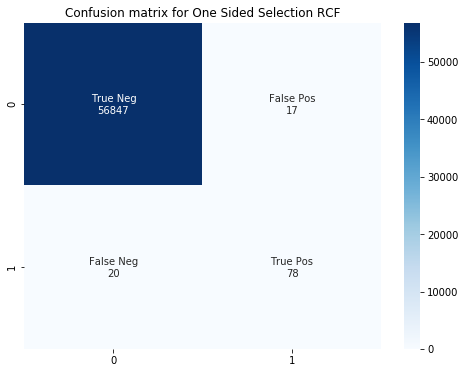

In [126]:
cf_matrix = top_3[0][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for One Sided Selection RCF")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [127]:
print(top_3[0][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.80      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



2. Tomek Links RCF

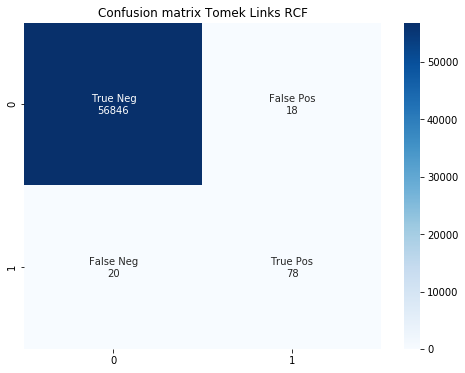

In [128]:
cf_matrix = top_3[1][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix Tomek Links RCF")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [129]:
print(top_3[1][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.80      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



3. One sided selection Forward feature selection

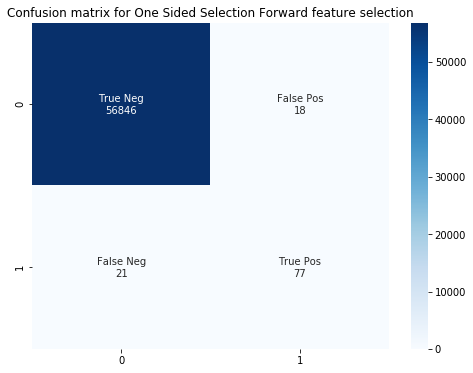

In [130]:
cf_matrix = top_3[2][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for One Sided Selection Forward feature selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [131]:
print(top_3[2][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.79      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962



## Working with different dataset

In [49]:
dataset2 = pd.read_csv("dataset2.csv")
dataset2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [50]:
dataset2.shape

(6362620, 11)

In [51]:
dataset2.isnull().values.any()

False

In [52]:
dataset2.drop("isFlaggedFraud",axis=1,inplace=True)


In [53]:
all_zero=list(dataset2.loc[dataset2["isFraud"]==0].index)

In [54]:
sample_zero = np.random.choice(all_zero,200000,replace=False)

In [55]:
all_one=list(dataset2.loc[dataset2["isFraud"]==1].index)

In [56]:
selected_sample = np.concatenate([sample_zero,all_one])

In [57]:
len(selected_sample)

108213

In [58]:
new_dataset2 = dataset2.loc[selected_sample]

In [59]:
new_dataset2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
88009,10,CASH_OUT,69627.40,C1600630764,0.00,0.00,C1195378184,8602348.84,8671976.24,0
3557945,260,CASH_OUT,149294.68,C797350626,63569.00,0.00,C620614622,0.00,149294.68,0
5540034,382,PAYMENT,30295.74,C771505589,0.00,0.00,M1077474157,0.00,0.00,0
1097429,130,PAYMENT,27665.11,C1367351937,0.00,0.00,M250303556,0.00,0.00,0
646751,35,CASH_IN,208229.82,C1741646475,4201549.21,4409779.03,C405935487,316289.70,108059.88,0


In [60]:
y=new_dataset2['isFraud']
new_dataset2.drop('isFraud',axis=1,inplace=True)
X=new_dataset2

Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [61]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = - 1

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [63]:
X['errorbalanceOrg'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorbalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

In [64]:
# log transformed amount
X['ln_amount'] = np.log1p(X['amount'])

In [65]:
# correcting few negative errors
X['errorbalanceOrg'] = X['errorbalanceOrg'].apply(lambda x: 0 if x < 0 else x)

# log transformed origin account balance error
X['ln_errorBalanceOrig'] = np.log1p(X['errorbalanceOrg'])

In [66]:
X['errorbalanceDest'] = X['errorbalanceDest'].apply(lambda x: 0 if x < 0 else x)

# log transformed origin account balance error
X['ln_errorBalanceDest'] = np.log1p(X['errorbalanceDest'])

In [67]:
X["type"].value_counts()

CASH_OUT    39344
PAYMENT     33736
CASH_IN     21981
TRANSFER    12490
DEBIT         662
Name: type, dtype: int64

In [68]:
X["type_transfer"]=X["type"].replace({'CASH_OUT':0,'PAYMENT':1,'CASH_IN':2,'TRANSFER':3,'DEBIT':4})

In [69]:
X.drop("type",axis=1,inplace=True)

In [70]:
X.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,errorbalanceOrg,errorbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer
88009,10,69627.40,C1600630764,0.00,0.00,C1195378184,8602348.84,8671976.24,69627.40,0.00,11.150928,11.150928,0.000000,0
3557945,260,149294.68,C797350626,63569.00,0.00,C620614622,0.00,149294.68,85725.68,0.00,11.913684,11.358919,0.000000,0
5540034,382,30295.74,C771505589,0.00,0.00,M1077474157,-1.00,-1.00,30295.74,30295.74,10.318795,10.318795,10.318795,1
1097429,130,27665.11,C1367351937,0.00,0.00,M250303556,-1.00,-1.00,27665.11,27665.11,10.227963,10.227963,10.227963,1
646751,35,208229.82,C1741646475,4201549.21,4409779.03,C405935487,316289.70,108059.88,416459.64,416459.64,12.246402,12.939547,12.939547,2


In [71]:
X.drop(["amount","errorbalanceOrg","errorbalanceDest"],axis=1,inplace=True)


In [72]:
X.head()

,step,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer
88009,10,C1600630764,0.00,0.00,C1195378184,8602348.84,8671976.24,11.150928,11.150928,0.000000,0
3557945,260,C797350626,63569.00,0.00,C620614622,0.00,149294.68,11.913684,11.358919,0.000000,0
5540034,382,C771505589,0.00,0.00,M1077474157,-1.00,-1.00,10.318795,10.318795,10.318795,1
1097429,130,C1367351937,0.00,0.00,M250303556,-1.00,-1.00,10.227963,10.227963,10.227963,1
646751,35,C1741646475,4201549.21,4409779.03,C405935487,316289.70,108059.88,12.246402,12.939547,12.939547,2


In [73]:
X["type_name"]=X.step

In [74]:
X.loc[(X.nameOrig.str.contains("C")) & (X.nameDest.str.contains("C")),"type_name"]=0
X.loc[(X.nameOrig.str.contains("C")) & (X.nameDest.str.contains("M")),"type_name"]=1
X.loc[(X.nameOrig.str.contains("M")) & (X.nameDest.str.contains("C")),"type_name"]=2
X.loc[(X.nameOrig.str.contains("M")) & (X.nameDest.str.contains("M")),"type_name"]=3

In [75]:
X.tail()

,step,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer,type_name
6362615,743,C786484425,339682.13,0.0,C776919290,0.00,339682.13,12.735768,0.0,0.000000e+00,0,0
6362616,743,C1529008245,6311409.28,0.0,C1881841831,-1.00,-1.00,15.657870,0.0,1.565787e+01,3,0
6362617,743,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,15.657870,0.0,9.950331e-03,0,0
6362618,743,C1685995037,850002.52,0.0,C2080388513,-1.00,-1.00,13.652996,0.0,1.365300e+01,3,0
6362619,743,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,13.652996,0.0,9.313226e-10,0,0


In [76]:
X.drop(["nameOrig","nameDest"],axis=1,inplace=True)

In [77]:
X.head()

,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer,type_name
88009,10,0.00,0.00,8602348.84,8671976.24,11.150928,11.150928,0.000000,0,0
3557945,260,63569.00,0.00,0.00,149294.68,11.913684,11.358919,0.000000,0,0
5540034,382,0.00,0.00,-1.00,-1.00,10.318795,10.318795,10.318795,1,1
1097429,130,0.00,0.00,-1.00,-1.00,10.227963,10.227963,10.227963,1,1
646751,35,4201549.21,4409779.03,316289.70,108059.88,12.246402,12.939547,12.939547,2,0


In [78]:
#first proceed without step column
step_col = X.step
X.drop("step",axis=1,inplace=True)


In [79]:
X.head()

,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer,type_name
88009,0.00,0.00,8602348.84,8671976.24,11.150928,11.150928,0.000000,0,0
3557945,63569.00,0.00,0.00,149294.68,11.913684,11.358919,0.000000,0,0
5540034,0.00,0.00,-1.00,-1.00,10.318795,10.318795,10.318795,1,1
1097429,0.00,0.00,-1.00,-1.00,10.227963,10.227963,10.227963,1,1
646751,4201549.21,4409779.03,316289.70,108059.88,12.246402,12.939547,12.939547,2,0


In [80]:
# dividing into training and testing

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify = y)

In [82]:
X.isnull().values.any()

False

In [ ]:
cols=["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","ln_amount","ln_errorBalanceOrig","ln_errorBalanceDest"]
for c in cols:
    ss = StandardScaler()
    ss.fit(X_train.loc[:,str(c)].values.reshape(-1,1))
    transformed1 = ss.transform(X_train.loc[:,str(c)].values.reshape(-1,1))
    print(transformed1.shape)
    X_train["scaled_"+str(c)] = transformed1
    X_train.drop(c,axis=1,inplace=True)
    transformed2 = ss.transform(X_test.loc[:,str(c)].values.reshape(-1,1))
    X_test["scaled_"+str(c)] = transformed2
    X_test.drop(c,axis=1,inplace=True)
    

In [84]:
X_train.head()

,type_transfer,type_name,scaled_oldbalanceOrg,scaled_newbalanceOrig,scaled_oldbalanceDest,scaled_newbalanceDest,scaled_ln_amount,scaled_ln_errorBalanceOrig,scaled_ln_errorBalanceDest
6037051,0,0,-0.303450,-0.281956,-0.144127,-0.153723,0.165922,0.568628,-1.087746
3999924,0,0,-0.303960,-0.281956,-0.050936,-0.023459,0.767283,0.788869,-1.087746
6194797,3,0,0.133850,-0.281956,-0.308519,-0.323733,1.616743,-1.576486,1.510104
580217,0,0,-0.303960,-0.281956,-0.248970,0.059103,0.271052,0.610026,-1.087746
1302959,2,0,6.033835,6.289040,0.656706,0.502178,0.554512,0.843732,1.265746


#### 1. Random Undersample

In [44]:
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
all_dataset["X_train_undersample_dataset2"], all_dataset["y_train_undersample_dataset2"] = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(all_dataset["y_train_undersample_dataset2"]))

Counter({0: 6570, 1: 6570})


In [45]:
training_testing_function(all_dataset["X_train_undersample_dataset2"],all_dataset["y_train_undersample_dataset2"],"Random Undersample dataset 2")

Random Undersample dataset 2 RCF Completed
Random Undersample dataset 2 Random Forest Selection Completed
Random Undersample dataset 2 Forward feature selection Completed


#### 2. Instance Hardness Threshold

In [46]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [47]:
iht = InstanceHardnessThreshold(sampling_strategy='majority', random_state=42)
all_dataset["X_train_res_dataset2"], all_dataset["y_train_res_dataset2"] = iht.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(all_dataset["y_train_res_dataset2"]))

Resampled dataset shape Counter({0: 158431, 1: 6570})


In [48]:
training_testing_function(all_dataset["X_train_res_dataset2"],all_dataset["y_train_res_dataset2"],"IHT dataset 2")

IHT dataset 2 RCF Completed
IHT dataset 2 Random Forest Selection Completed
IHT dataset 2 Forward feature selection Completed


#### 3. Cluster Centroid

In [46]:
y_train.value_counts()

0    160000
1      6570
Name: isFraud, dtype: int64

In [47]:
from imblearn.under_sampling import ClusterCentroids

In [85]:
all_dataset["X_cluster_centroids_dataset2"],all_dataset["y_cluster_centroids_dataset2"]  = ClusterCentroids().fit_resample(X_train,y_train)

In [86]:
training_testing_function(all_dataset["X_cluster_centroids_dataset2"],all_dataset["y_cluster_centroids_dataset2"],"Cluster centroids dataset 2")

Cluster centroids dataset 2 RCF Completed
Cluster centroids dataset 2 Random Forest Selection Completed
Cluster centroids dataset 2 Forward feature selection Completed


In [87]:
all_results

[('Tomek Links dataset 2 RCF',
  0.9974785678265254,
  0.9689073141841872,
  0.996644750456482,
  array([[39902,    98],
         [    7,  1636]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       0.94      1.00      0.97      1643\n\n    accuracy                           1.00     41643\n   macro avg       0.97      1.00      0.98     41643\nweighted avg       1.00      1.00      1.00     41643\n'),
 ('Tomek Links dataset 2 Random Forest  Selection',
  0.9997358499627789,
  0.9966432712847115,
  0.9969442863664029,
  array([[39999,     1],
         [   10,  1633]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       1.00      0.99      1.00      1643\n\n    accuracy                           1.00     41643\n   macro avg       1.00      1.00      1.00     41643\nweighted avg       1.00      1.00

#### 4. Near Miss

In [49]:
from imblearn.under_sampling import NearMiss

In [50]:
all_dataset['X_near_miss_dataset2'],all_dataset['y_near_miss_dataset2'] = NearMiss().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_near_miss_dataset2'],all_dataset['y_near_miss_dataset2'],"Near Miss dataset 2")

Near Miss dataset 2 RCF Completed
Near Miss dataset 2 Random Forest Selection Completed


C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Near Miss dataset 2 Forward feature selection Completed


In [67]:
all_dataset['y_near_miss_dataset2'].values

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [ ]:
all_results

#### 5. One Sided Selection

In [51]:
from imblearn.under_sampling import OneSidedSelection

In [52]:
all_dataset['X_one_sided_selection_dataset2'],all_dataset['y_one_sided_selection_dataset2'] = OneSidedSelection().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_one_sided_selection_dataset2'],all_dataset['y_one_sided_selection_dataset2'],"One Sided Selection dataset 2")

One Sided Selection dataset 2 RCF Completed
One Sided Selection dataset 2 Random Forest Selection Completed
One Sided Selection dataset 2 Forward feature selection Completed


In [72]:
all_results

[('Near Miss dataset 2 RCF',
  0.4844511682635737,
  0.12095156205216395,
  0.6831951536822884),
 ('Near Miss dataset 2 Random Forest  Selection',
  0.33410176980524936,
  0.09609492144207575,
  0.6040571895922093),
 ('Near Miss dataset 2 Forward feature selection',
  0.3651514059986072,
  0.10392163508795717,
  0.6374371500304321),
 ('Near Miss dataset 2 RCF',
  0.4844511682635737,
  0.12095156205216395,
  0.6831951536822884),
 ('Near Miss dataset 2 Random Forest  Selection',
  0.331844487668996,
  0.09580137787599116,
  0.6028821895922094),
 ('Near Miss dataset 2 Forward feature selection',
  0.3651514059986072,
  0.10392163508795717,
  0.6374371500304321),
 ('One Sided Selection dataset 2 RCF',
  0.9965420358763778,
  0.9573712255772646,
  0.9906126445526475),
 ('One Sided Selection dataset 2 Random Forest  Selection',
  0.9981749633791994,
  0.977245508982036,
  0.9958399650030433),
 ('One Sided Selection dataset 2 Forward feature selection',
  0.9970943495905674,
  0.9642540620384

#### 6. Tomek Links

In [41]:
from imblearn.under_sampling import TomekLinks

In [42]:
all_dataset['X_tomek_links_dataset2'],all_dataset['y_tomek_links_dataset2'] = TomekLinks().fit_resample(X_train,y_train)


In [43]:
training_testing_function(all_dataset['X_tomek_links_dataset2'],all_dataset['y_tomek_links_dataset2'],"Tomek Links dataset 2")

Tomek Links dataset 2 RCF Completed
Tomek Links dataset 2 Random Forest Selection Completed
Tomek Links dataset 2 Forward feature selection Completed


In [44]:
all_results

[('Tomek Links dataset 2 RCF',
  0.9974785678265254,
  0.9689073141841872,
  0.996644750456482,
  array([[39902,    98],
         [    7,  1636]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       0.94      1.00      0.97      1643\n\n    accuracy                           1.00     41643\n   macro avg       0.97      1.00      0.98     41643\nweighted avg       1.00      1.00      1.00     41643\n'),
 ('Tomek Links dataset 2 Random Forest  Selection',
  0.9997358499627789,
  0.9966432712847115,
  0.9969442863664029,
  array([[39999,     1],
         [   10,  1633]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       1.00      0.99      1.00      1643\n\n    accuracy                           1.00     41643\n   macro avg       1.00      1.00      1.00     41643\nweighted avg       1.00      1.00

### Oversampling data

#### 1. Random Oversampling

In [54]:
ros = RandomOverSampler(random_state=0)
all_dataset["X_train_random_oversampled_dataset2"], all_dataset["y_train_random_oversampled_dataset2"] = ros.fit_resample(X_train, y_train)

print(sorted(Counter(all_dataset["y_train_random_oversampled_dataset2"]).items()))

[(0, 160000), (1, 160000)]


In [55]:
training_testing_function(all_dataset["X_train_random_oversampled_dataset2"],all_dataset["y_train_random_oversampled_dataset2"],"Random Oversampled dataset2")

Random Oversampled dataset2 RCF Completed
Random Oversampled dataset2 Random Forest Selection Completed
Random Oversampled dataset2 Forward feature selection Completed


#### 2. SMOTE

In [56]:
from imblearn.over_sampling import SMOTE, ADASYN
all_dataset["X_smote_dataset2"], all_dataset["y_smote_dataset2"] = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_smote_dataset2"]).items()))



[(0, 160000), (1, 160000)]


In [57]:
training_testing_function(all_dataset['X_smote_dataset2'],all_dataset['y_smote_dataset2'],"SMOTE dataset2")

SMOTE dataset2 RCF Completed
SMOTE dataset2 Random Forest Selection Completed
SMOTE dataset2 Forward feature selection Completed


#### 3. ADASYN

In [58]:
all_dataset['X_adasyn_dataset2'],all_dataset['y_adasyn_dataset2'] = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_adasyn_dataset2"]).items()))

[(0, 160000), (1, 160038)]


In [59]:
training_testing_function(all_dataset['X_adasyn_dataset2'],all_dataset['y_adasyn_dataset2'],"ADASYN dataset2")

ADASYN dataset2 RCF Completed
ADASYN dataset2 Random Forest Selection Completed
ADASYN dataset2 Forward feature selection Completed


#### 4. Variations of SMOTE

In [60]:
from imblearn.over_sampling import BorderlineSMOTE,SVMSMOTE,KMeansSMOTE

In [61]:
all_dataset["X_borderline_smote_dataset2"],all_dataset["y_borderline_smote_dataset2"] = BorderlineSMOTE().fit_resample(X_train,y_train)
all_dataset["X_svm_smote_dataset2"],all_dataset["y_svm_smote_dataset2"] = SVMSMOTE().fit_resample(X_train,y_train)

# X_kmeans_smote,y_kmeans_smote = KMeansSMOTE().fit_resample(X_train,y_train)


# all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"]= X_kmeans_smote,y_kmeans_smote

training_testing_function(all_dataset["X_borderline_smote_dataset2"],all_dataset["y_borderline_smote_dataset2"],"Borderline SMOTE dataset2")
training_testing_function(all_dataset["X_svm_smote_dataset2"],all_dataset["y_svm_smote_dataset2"],"SVM SMOTE dataset2")

# training_testing_function(all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"],"KMeans SMOTE")



Borderline SMOTE dataset2 RCF Completed
Borderline SMOTE dataset2 Random Forest Selection Completed
Borderline SMOTE dataset2 Forward feature selection Completed
SVM SMOTE dataset2 RCF Completed
SVM SMOTE dataset2 Random Forest Selection Completed
SVM SMOTE dataset2 Forward feature selection Completed


### Combination of Undersampling and Oversampling

#### 1. SMOTETomek

In [62]:
from imblearn.combine import SMOTETomek

In [63]:
all_dataset['X_smote_tomek_dataset2'],all_dataset['y_smote_tomek_dataset2'] = SMOTETomek().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_smote_tomek_dataset2'],all_dataset['y_smote_tomek_dataset2'],"SMOTE Tomek dataset2")

SMOTE Tomek dataset2 RCF Completed
SMOTE Tomek dataset2 Random Forest Selection Completed
SMOTE Tomek dataset2 Forward feature selection Completed


In [64]:
all_results

[('Random Undersample dataset 2 RCF',
  0.986864539058185,
  0.8568437581784872,
  0.9914115718198417,
  array([[39459,   541],
         [    6,  1637]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99     40000\n           1       0.75      1.00      0.86      1643\n\n    accuracy                           0.99     41643\n   macro avg       0.88      0.99      0.92     41643\nweighted avg       0.99      0.99      0.99     41643\n'),
 ('Random Undersample dataset 2 Random Forest  Selection',
  0.9992555771678313,
  0.9906145927944293,
  0.9975697504564819,
  array([[39976,    24],
         [    7,  1636]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       0.99      1.00      0.99      1643\n\n    accuracy                           1.00     41643\n   macro avg       0.99      1.00      1.00     41643\nweighted avg       

In [75]:
top_3 = sorted(all_results,key=lambda x: x[2],reverse=True)[:3]
top_3

[('Borderline SMOTE dataset2 Forward feature selection',
  0.9998319045217684,
  0.9978652028057334,
  0.997869750456482,
  array([[40000,     0],
         [    7,  1636]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       1.00      1.00      1.00      1643\n\n    accuracy                           1.00     41643\n   macro avg       1.00      1.00      1.00     41643\nweighted avg       1.00      1.00      1.00     41643\n'),
 ('Random Oversampled dataset2 Random Forest  Selection',
  0.9998078908820209,
  0.9975609756097561,
  0.997857250456482,
  array([[39999,     1],
         [    7,  1636]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       1.00      1.00      1.00      1643\n\n    accuracy                           1.00     41643\n   macro avg       1.00      1.00      1.00     41643\nwe

### Confusion matrix of top 3 performers

1. Borderline SMOTE dataset2 Forward feature selection

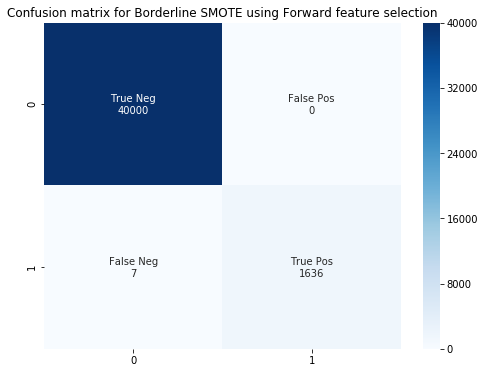

In [85]:
cf_matrix = top_3[0][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Borderline SMOTE using Forward feature selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [87]:
print(top_3[0][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00     41643
   macro avg       1.00      1.00      1.00     41643
weighted avg       1.00      1.00      1.00     41643



2. Random Oversampled dataset2 Random Forest  Selection

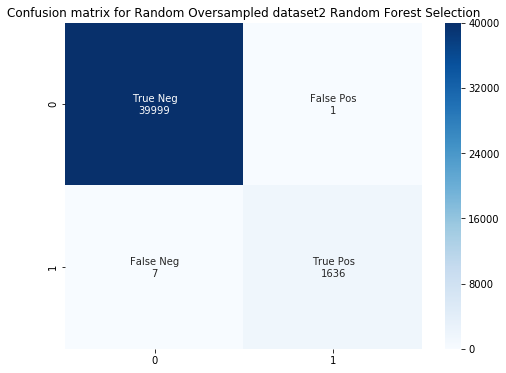

In [88]:
cf_matrix = top_3[1][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Random Oversampled dataset2 Random Forest Selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [89]:
print(top_3[1][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00     41643
   macro avg       1.00      1.00      1.00     41643
weighted avg       1.00      1.00      1.00     41643



3. Borderline SMOTE dataset2 Random Forest  Selection

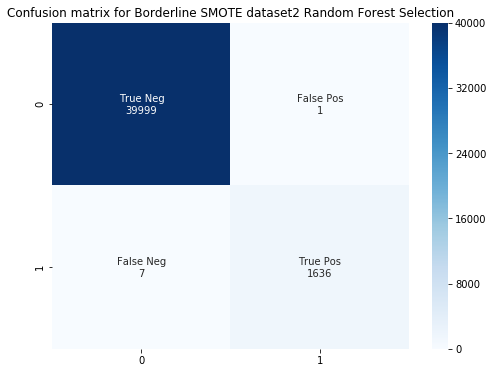

In [90]:
cf_matrix = top_3[2][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Borderline SMOTE dataset2 Random Forest Selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [91]:
print(top_3[2][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00     41643
   macro avg       1.00      1.00      1.00     41643
weighted avg       1.00      1.00      1.00     41643



In [92]:
all_results

[('Random Undersample dataset 2 RCF',
  0.986864539058185,
  0.8568437581784872,
  0.9914115718198417,
  array([[39459,   541],
         [    6,  1637]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99     40000\n           1       0.75      1.00      0.86      1643\n\n    accuracy                           0.99     41643\n   macro avg       0.88      0.99      0.92     41643\nweighted avg       0.99      0.99      0.99     41643\n'),
 ('Random Undersample dataset 2 Random Forest  Selection',
  0.9992555771678313,
  0.9906145927944293,
  0.9975697504564819,
  array([[39976,    24],
         [    7,  1636]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     40000\n           1       0.99      1.00      0.99      1643\n\n    accuracy                           1.00     41643\n   macro avg       0.99      1.00      1.00     41643\nweighted avg       